# Wine analisys

This notebook containes some data analysis and ML insight into dataset about wines. The data set was taken from Kaggle and can be fount [here](https://www.kaggle.com/zynicide/wine-reviews).

In [1]:
import pandas as pd
from pathlib import Path
import os
import re
import seaborn as sns
import math
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import typing
from copy import deepcopy
from collections import defaultdict

Define some variables

In [2]:
wine_table_name = "winemag-data_first150k.csv"

data_dir = Path('__file__').parent.resolve()/ 'data'

country = "country"
description = "description"
points = "points"
price = "price"
variety = "variety"
winery = "winery"
province = "province"
points_group = "points_group"
log10_price = "log10_price"

### Explore the data set

Load data set and remove duplicate rows.
Initally the data set contains 10 variables of different types. I'll use only 7 here: country of origin, descrition of wine, points given to the wine by sommelier, wine price, grape variety, privince and winery. The data types can be found below along with glimpse of the whole data set after initial cleaning.

In [3]:
table_full = pd.read_csv(data_dir / wine_table_name, index_col=0)

print(f"Table name: {wine_table_name}")
print('\n')
print(f"This table has {len(table_full)} rows.")
data = table_full.drop_duplicates()
print(f"With duplicates removed, the table has {len(data)} rows.")

print('\n')
print(f'Table data types by column')
print(data.dtypes)
print('\n')

required_columns = [country, description, points, price, variety, province, winery]
data = data[required_columns]

print(f"Subset of the data has columns: {required_columns}")

data


Table name: winemag-data_first150k.csv


This table has 150930 rows.
With duplicates removed, the table has 97851 rows.


Table data types by column
country         object
description     object
designation     object
points           int64
price          float64
province        object
region_1        object
region_2        object
variety         object
winery          object
dtype: object


Subset of the data has columns: ['country', 'description', 'points', 'price', 'variety', 'province', 'winery']


,country,description,points,price,variety,province,winery
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,Cabernet Sauvignon,California,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro,Northern Spain,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc,California,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Pinot Noir,Oregon,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence red blend,Provence,Domaine de la Bégude
...,...,...,...,...,...,...,...
149635,US,A Syrah-Grenache blend that's dry and rustical...,84,15.0,Syrah-Grenache,California,Casa Barranca
149636,Portugal,Oreo eaters will enjoy the aromas of this wine...,84,NaN,Port,Port,Casa Santa Eufemia
149637,US,"Outside of the vineyard, wines like this are w...",84,6.0,Merlot,California,Delicato
149638,Argentina,"Heavy and basic, with melon and pineapple arom...",84,9.0,Sauvignon Blanc,Mendoza Province,Finca El Portillo


According to data description in the source, points can vary from 1 to 100. The currency is not stated, but since the web site from where the data was scraped represents American company, I'll assume that the price is in USD dollars. 

Now need to check if there are any missing values.

The column with price has the largest amount of missing values and just 3 observations have missing country. Since the number of missing prices is relatively big, just dropping them would result in noticeable data loss. So need to replace them with some meaningful value. And can drop 3 examples where ther is no country. 

In [4]:
for column_name in required_columns:
    column = data[[column_name]]
    na_values = column.isna().sum(axis=0)[column_name]
    print(f"Column '{column_name}' has {na_values} missing values.")

Column 'country' has 3 missing values.
Column 'description' has 0 missing values.
Column 'points' has 0 missing values.
Column 'price' has 8720 missing values.
Column 'variety' has 0 missing values.
Column 'province' has 3 missing values.
Column 'winery' has 0 missing values.


Let's actually check what range of points is represented here:

In [5]:
max_points = data[points].max()
min_points = data[points].min()

print(f"Points highest: {max_points}")
print(f"Points lowest: {min_points}")

Points highest: 100
Points lowest: 80


So in this data set wines that got less than 80 points are not considered.  

I'm going to replace missing values for price with the median, but the median obtained from the whole set doesn't seem to be the most precise. Better to split the data set by points into several groups and use the median per group. Here I'll use 4 groups.

In [6]:
# calculate points ranges
slices = 4
increment = (max_points - min_points) / slices
ranges = [(math.floor(i * increment), math.floor((i+1) * increment)) for i in range(slices)]


In [7]:
# TODO move it to helper functions
cols = 2
if slices > cols:
    rows = math.ceil(slices/cols)
else:
    rows = 1
    
    
def get_row_and_column_index(max_row: int, max_col: int):
    row, col = 0, -1
    for element_number in range(max_row * max_col):
        if element_number > max_col - 1:
            max_col += max_col
            row += 1
            col = 0
        else:
            col += 1
        yield row, col       
         

## Exploratory plots

Let's make some explorative analysis and plots for prices and scores.
Start with some descriptive statistics for prices:

In [8]:
stats = data[price].describe()
print( "Number of observations: {0}\n \
        Min: {1:.2f}\n \
        1st Quartile: {2:.2f}\n \
        Mean: {3:.2f}\n \
        Median: {4:.2f}\n \
        3rd Quartile: {5:.2f}\n \
        Max: {6:.2f}".format(stats['count'], stats['min'], stats['25%'], stats['mean'], stats['50%'], stats['75%'], stats['max']))


Number of observations: 89131.0
         Min: 4.00
         1st Quartile: 16.00
         Mean: 33.66
         Median: 25.00
         3rd Quartile: 40.00
         Max: 2300.00


By looking at these numbers, one can say that the data is right-skewed. Median and mean are not equal. Also 75% percent of all wines have price \\$40 or below, while the highest price reaches \\$2300. This suggests that the data for wine prices is not normally distributed.

Text(0.5, 1.0, 'Wine price vs wine points given by sommelier')

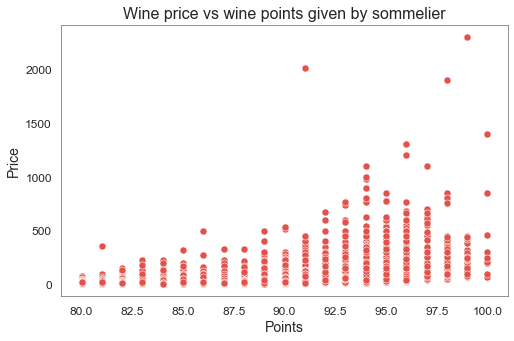

In [9]:
params_dict = \
    {'figure.figsize':(8,5),
     'axes.labelsize': 14.0,
     'xtick.labelsize': 12.0,
     'ytick.labelsize': 12.0,
     'lines.linewidth': 2,
     'axes.linewidth': 0.5,
     'grid.linewidth': 1,
 }
sns.set_theme(rc=params_dict, style='white', palette='Spectral')
sns.scatterplot(data=data, x=points, y=price, s=50)
plt.xlabel("Points")
plt.ylabel("Price")
plt.title("Wine price vs wine points given by sommelier", size=16)


Based on this plot, it is hard to say whether there is link between wine score and price.

The below a 2 histograms for wine prices: one for original prices and one for prices after computing logarithm with base 10. This is a common transformation applied to skewed data to make it closer to "bell shaped" and it preserves original relationships and patterns in data. As can be seen the original data is indeed very skewed, but log-transformation makes it much more "normal". For future data analysis it might be more appropriate to use this log-transformed data instead, but for now let's look into original prices little more.

Text(0.5, 1.0, 'Histogram of wine prices on log-scale')

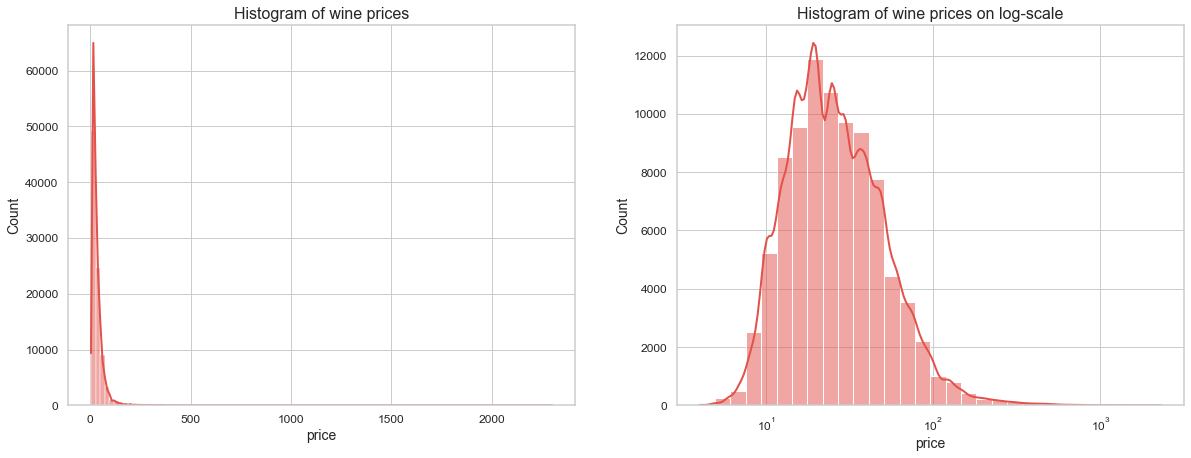

In [10]:
params_dict = \
    {'figure.figsize':(10,7),
     'axes.labelsize': 14.0,
     'xtick.labelsize': 12.0,
     'ytick.labelsize': 12.0,
     'lines.linewidth': 2,
     'axes.linewidth': 1.5,
     'grid.linewidth': 1,
 }
sns.set_theme(rc=params_dict, style='whitegrid', palette='Spectral')
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.histplot(data, x=price, kde=True, bins=100, ax=ax[0])
ax[0].set_title("Histogram of wine prices", size=16)

sns.histplot(data, x=price, kde=True, bins=30, ax=ax[1], log_scale=True)
ax[1].set_title("Histogram of wine prices on log-scale", size=16)

Let's plots some boxplots of wine prices per points group, just to see what we are dealing with. While doing this also calculate some descriptive statistics including medians, which will be used for replacement.

Prices for scores from 80 to 84
Group size: 13996 observations
Mean: 18.78
Median: 15.00
Standard deviation: 12.61
Min: 4.00
Max: 354.00


Prices for scores from 85 to 89
Group size: 46488 observations
Mean: 25.58
Median: 20.00
Standard deviation: 17.55
Min: 4.00
Max: 500.00


Prices for scores from 90 to 94
Group size: 27015 observations
Mean: 49.24
Median: 40.00
Standard deviation: 41.25
Min: 5.00
Max: 2013.00


Prices for scores from 95 to 100
Group size: 1632 observations
Mean: 133.40
Median: 85.00
Standard deviation: 146.59
Min: 20.00
Max: 2300.00




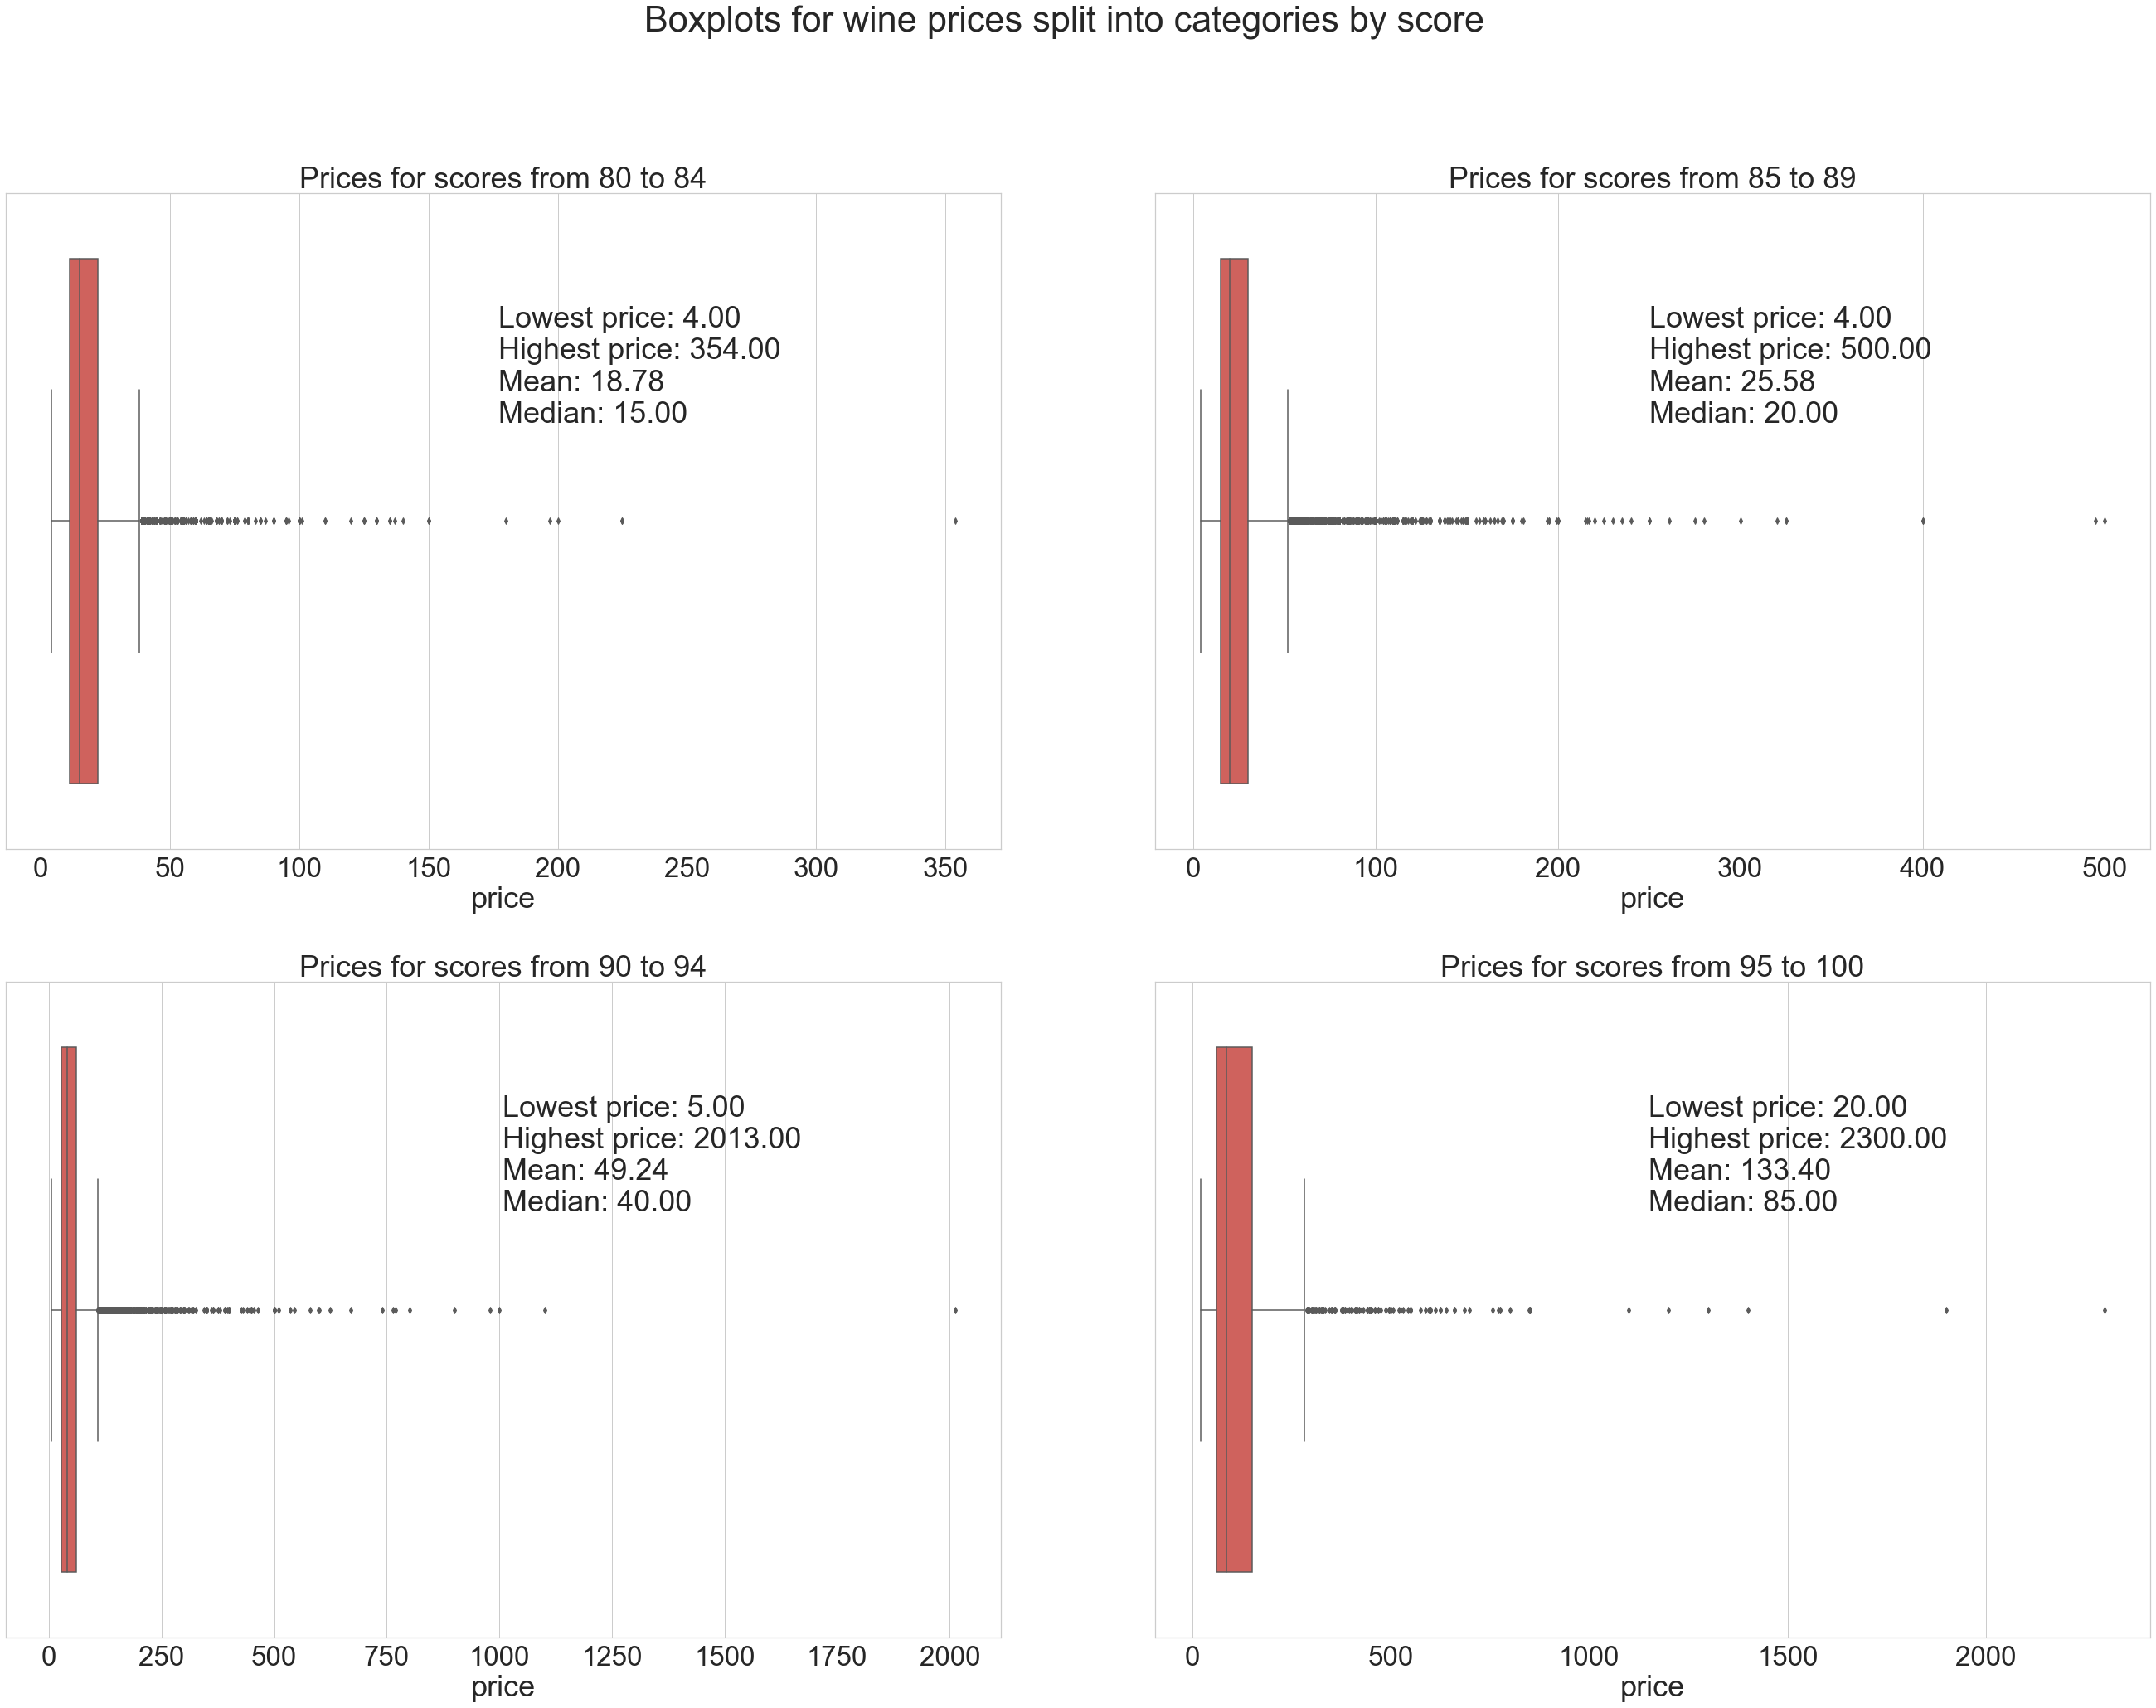

In [11]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=3)

fig, ax = plt.subplots(rows, cols, figsize=(40, 30))
fig.suptitle("Boxplots for wine prices split into categories by score")#, size=32)
fig.tight_layout(pad=3)

data_to_replace_nulls = []

coord_generator = get_row_and_column_index(rows, cols)
for i, (bottom, top) in enumerate(ranges):   
    bottom += min_points
    top += min_points
    if i == len(ranges)-1:
        top += 1
    subset = data[data[points].isin(range(bottom, top))]
    subset = subset[~subset[price].isna()]
    
    stats = subset[price].describe()
    mean = stats['mean']   
    median = stats['50%']
    max_price = stats['max']
    min_price = stats['min']
    std = stats['std']
    
    data_to_replace_nulls.append(((range(bottom, top)), median))
        
    print(f"Prices for scores from {bottom} to {top-1}")
    print(f"Group size: {len(subset)} observations")
    print("Mean: {0:.2f}".format(mean))
    print("Median: {0:.2f}".format(median))
    print("Standard deviation: {0:.2f}".format(std))
    print("Min: {0:.2f}".format(min_price))
    print("Max: {0:.2f}".format(max_price))
    print('\n')
    coord = next(coord_generator)
    sns.boxplot(x=subset[price], ax=ax[coord[0], coord[1]])
    ax[coord[0], coord[1]].set_title(f"Prices for scores from {bottom} to {top-1}")#, size=44)
    ax[coord[0], coord[1]].text(max_price - max_price/2, -0.15,
                                "Lowest price: {:.2f}\nHighest price: {:.2f}\nMean: {:.2f}\nMedian: {:.2f}".format(min_price, max_price, mean, median))

By looking onto these plots, we can say that the data in each group is quite skewed, so has outliers, i.e. unusally pricy bottles of wine for a particular group. This can also confirmed by the fact that means and medians are not equal. Also, we can say that the range of prices tends to get bigger the higher the score. This is reflected in groups maximum price, which gets higher and also mean and median prices get substantially higher too. However, apart from the last group with the highest scores, the rest have pretty much same starting price. From these plots it is not completely clear if the prices majority per group are that much different.

#### Dealing with missing values and adding new columns

In [12]:
# replace missing prices with median
for range_, replacement in data_to_replace_nulls:
    subset = data[data[points].isin(range_)]
    subset = subset[~subset[price].isna()]
    mask = data[points].isin(range_) & data[price].isna()
    data[price].mask(mask, replacement, inplace=True)
    

For future analysis need to create a new column that will have score group name and another column with log base 10 of wine prices.

In [13]:
for range_, _ in data_to_replace_nulls:
    group_string = f"{range_[0]} to {range_[-1]}"
    mask = data[points].isin(range_) 
    data.loc[mask, points_group] = group_string
data[log10_price] = np.log10(data[price])
    
data.head()

,country,description,points,price,variety,province,winery,points_group,log10_price
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,Cabernet Sauvignon,California,Heitz,95 to 100,2.371068
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro,Northern Spain,Bodega Carmen Rodríguez,95 to 100,2.041393
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc,California,Macauley,95 to 100,1.954243
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Pinot Noir,Oregon,Ponzi,95 to 100,1.812913
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence red blend,Provence,Domaine de la Bégude,95 to 100,1.819544


Let's ensure that there are no missing values now. For now will leave missing countries.

In [14]:
for column_name in required_columns:
    column = data[[column_name]]
    na_values = column.isna().sum(axis=0)[column_name]
    print(f"Column '{column_name}' has {na_values} missing values.")
    
print(f"Table has {len(data)} obsesrvations.")

Column 'country' has 3 missing values.
Column 'description' has 0 missing values.
Column 'points' has 0 missing values.
Column 'price' has 0 missing values.
Column 'variety' has 0 missing values.
Column 'province' has 3 missing values.
Column 'winery' has 0 missing values.
Table has 97851 obsesrvations.


### ANOVA

Since it wasn't entirely obvious whether there is a significant difference between wine groups (and in general making conclusions about data by only looking at sample plots isn't right) we'll performs an ANOVA (Analysis of Variance) on prices vs score groups. For ANOVA results to be interpretable, the groups have to follow normal distribution, hence need to use log-transformed data.

Checking sizes of groups, can note that they are not equal, but it still should be fine as long as they approximately normally distributed. And since distribution of all prices (log-transformed) is approximatelly normal, distribution in groups is normal too.

In [87]:
for group in data[points_group].unique():
    subset = data[data[points_group]==group]
    print(f"Group {group} points has {len(subset)} observations")


Group 95 to 100 points has 1912 observations
Group 90 to 94 points has 30375 observations
Group 85 to 89 points has 50939 observations
Group 80 to 84 points has 14625 observations


Will use ANOVA to test whether means of prices in different score groups are siginficantly different. For this test the Null Hypothesis is that all means across groups are equal, alternative - that there is at least one group that has different mean. Will conduct the test at 5% significance level.

In [91]:
print("ANOVA for log-transformed prices paer score group")
model = ols(f'{log10_price} ~ C({points_group})', data=data).fit()
anova_table_log = sm.stats.anova_lm(model, typ=2)
print(anova_table_log)

ANOVA for log-transformed prices paer score group
                      sum_sq       df             F  PR(>F)
C(points_group)  2732.253837      3.0  17800.606123     0.0
Residual         5006.249774  97847.0           NaN     NaN


From this result we are intersted in F-value (17800.606123) and p-value (0.0). For the null hypothesis to be rejected (meaning at least one group mean is different from others), the p-value must be less than chosen significance level (0.05). In this case, p-value is 0.0, which is <0.05. F-value on the other hand must be larger than the critical value, determined from F-distribution table using degrees of freedom (df column) provided in ANOVA result. For this setting the critical value is tiny compared to the result (2.6049). So taking both statistics into account, can conclude that at least one group mean price is statistically different from the rest. To determine which one (or more), need to conduct a post-hoc analysis. Note, the fact that there is difference in price means between groups, doesn't mean that score group is a good "predictor" for price (as can be approximately seen in  plot of score vs price).

To determine which group or groups are different, will conduct a Tukey HSD test that compares all possible pairs of means. 

In [92]:
# might take a while to compute
res_log = stat()
res_log.tukey_hsd(df=data, res_var=log10_price, xfac_var=points_group, anova_model=f'{log10_price} ~ C({points_group})')
res_log.tukey_summary

C:\Users\user\anaconda3\envs\data_analysis_env\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,95 to 100,90 to 94,0.374866,0.361165,0.388568,99.402362,0.001
1,95 to 100,85 to 89,0.650086,0.636549,0.663622,174.480214,0.001
2,95 to 100,80 to 84,0.777223,0.763091,0.791355,199.820728,0.001
3,90 to 94,85 to 89,0.275220,0.271007,0.279432,237.358044,0.001
4,90 to 94,80 to 84,0.402357,0.396508,0.408206,249.936482,0.001
5,85 to 89,80 to 84,0.127137,0.121686,0.132589,84.729629,0.001


This result suggests that all groups are significantly different from each other at 5% siginificance level, since all p-values are <0.05. 

To check that data normality assumptions are satisified, can make some plots: quantile-quantile (Q-Q) plot of residual quantiles vs theoretical normal quantiles and histogram of residuals. Both help to asses how close the distribution of resudals is to normal distribution. For Q-Q plot we want points to be as close to $f(x)=x$ line (45°) as possible and we want histogram to be bell-shaped. By looking to the plots, it can be concluded that there obviously are some outliers, but the majority of the points seem to be close to normal distribution. So I'd consider that assumptions hold.

Text(0.5, 1.0, 'Histograms of residuals')

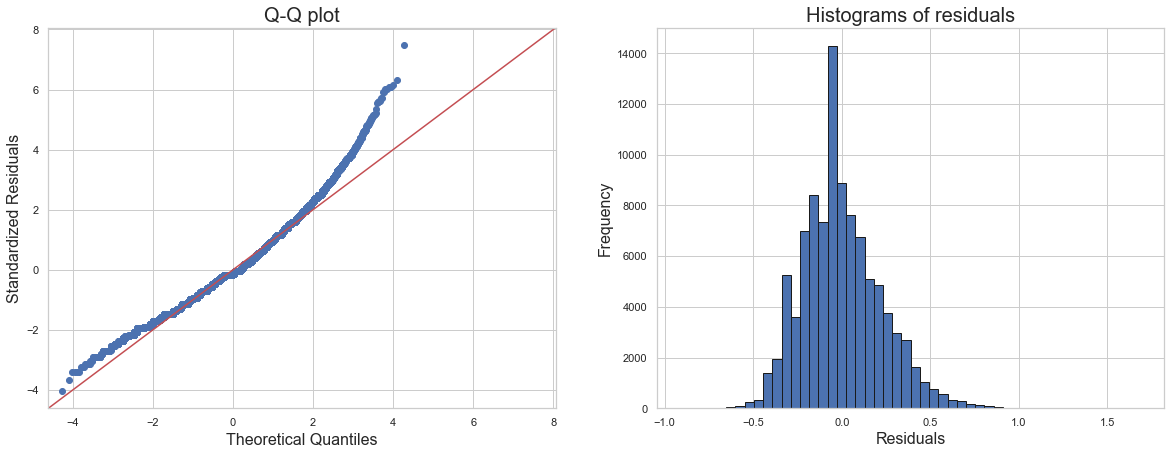

In [131]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sm.qqplot(res_log.anova_std_residuals, line='45', ax=ax[0])
ax[0].set_xlabel("Theoretical Quantiles", size=16)
ax[0].set_ylabel("Standardized Residuals", size=16)
ax[0].set_title("Q-Q plot", size=20)

plt.hist(res_log.anova_model_out.resid, bins=50, histtype='bar', ec='k') 
plt.xlabel("Residuals", size=16)
plt.ylabel('Frequency', size=16)
ax[1].set_title("Histograms of residuals", size=20)


So, it can be said that there is statistically significant difference in wine price between different score groups.

## Working with countries and wine descriptions

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
# nltk.download('omw-1.4')
# nltk.download("stopwords")
# nltk.download('words')
# nltk.download('brown')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
stop_words = set(stopwords.words("english"))
from nltk.stem import WordNetLemmatizer
# from wordcloud import WordCloud

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [20]:
# merge two word lists making sure not to duplicate
# food_list = deepcopy(food_list_nltk)
# nltk_food_as_str = ', '.join(food_list_nltk)
# for my_food_item in my_food_list:
#     if re.search(r"(^|, ){}(, |$)".format(my_food_item), nltk_food_as_str):
#         food_list.append(my_food_item)

In [65]:
# WORDS TO DESCRIBE FOOD AND WINE
with open(data_dir / 'words_to_describe_food_and_wine.txt', 'r') as f:
    description_words = f.read()
    
description_words = description_words.split('\n')
description_words = [i.lower().strip() for i in description_words if i]

In [61]:
where_zucchini_is = lambda x: "pork" in x.lower()

In [62]:
zucchini = descriptions[descriptions[description].apply(where_zucchini_is)]


In [103]:
for i, data in zucchini[:1].iterrows():
    desc = data[description]
    sentences = nltk.tokenize.sent_tokenize(desc)
    for sent in sentences:
        words = nltk.tokenize.word_tokenize(sent)
        print(nltk.pos_tag(words))
    # TODO using food words try to find "pair" words to find what the wine is good with
    # Using same words find "notes"
    print(desc)
    print('\n')

[('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('richer', 'JJR'), ('take', 'NN'), ('on', 'IN'), ('the', 'DT'), ('grape', 'NN'), (',', ','), ('with', 'IN'), ('aromas', 'NN'), ('of', 'IN'), ('baked', 'JJ'), ('cherries', 'NNS'), (',', ','), ('pie', 'NN'), ('crust', 'NN'), (',', ','), ('allspice', 'NN'), (',', ','), ('nutmeg', 'NN'), ('and', 'CC'), ('a', 'DT'), ('touch', 'NN'), ('of', 'IN'), ('bacon', 'NN'), ('fat', 'NN'), ('.', '.')]
[('The', 'DT'), ('palate', 'NN'), ('is', 'VBZ'), ('quite', 'RB'), ('juicy', 'NN'), (',', ','), ('accessible', 'JJ'), ('and', 'CC'), ('action-packed', 'JJ'), (',', ','), ('with', 'IN'), ('roasted', 'VBN'), ('pork', 'NN'), (',', ','), ('cherry', 'VBP'), ('jelly', 'RB'), (',', ','), ('blackberry', 'NN'), ('jam', 'NN'), (',', ','), ('star', 'NN'), ('anise', 'NN'), ('and', 'CC'), ('baking', 'NN'), ('spice', 'NN'), ('flavors', 'NNS'), ('deep', 'VBP'), ('into', 'IN'), ('the', 'DT'), ('finish', 'NN'), ('.', '.')]
This is a richer take on the grape, with aromas of baked

,description,number_of_sentences
0,This tremendous 100% varietal wine hails from ...,4
1,"Ripe aromas of fig, blackberry and cassis are ...",4
2,Mac Watson honors the memory of a wine once ma...,2
3,"This spent 20 months in 30% new French oak, an...",4
4,"This is the top wine from La Bégude, named aft...",5
5,"Deep, dense and pure from the opening bell, th...",5
6,Slightly gritty black-fruit aromas include a s...,4
7,Lush cedary black-fruit aromas are luxe and of...,5
8,This re-named vineyard was formerly bottled as...,5
9,The producer sources from two blocks of the vi...,3


In [65]:
english_words = set(nltk.corpus.words.words())
len(english_words)

235892

In [71]:
def text_preprocessing(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    words = nltk.tokenize.word_tokenize(text)
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if w.casefold() not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    words = [w for w in words if w.lower() in english_words]
    return ' '.join(words)

In [72]:

descriptions = [text_preprocessing(txt) for txt in descriptions]


In [35]:
print(descriptions[:10])

['tremendous varietal wine hail aged three year oak Juicy fruit compelling hint caramel greet palate framed elegant fine tannin subtle minty tone background Balanced rewarding start finish year ahead develop nuance Enjoy', 'Ripe aroma fig blackberry cassis oaky chocolate vanilla full layered intense cushioned palate rich flavor black fruit baking spice toasty everlasting finish heady ideally balanced Drink', 'Mac honor memory wine made mother tremendously delicious balanced complex white Dark gold color layer hazelnut pear compote orange peel flavor succulence residual sugar', 'spent month new oak fruit Aurora Madrona vineyard among Aromatic dense toasty deftly blend aroma flavor toast cigar box blackberry black cherry coffee graphite polished fine sheen frame finish loaded dark chocolate Drink', 'top wine La highest point vineyard foot structure density considerable acidity still month wood wine extra richness concentration Produced Tari family formerly wine made aging Drink', 'Deep d

In [107]:
vectorizer = CountVectorizer()
vectorizer.fit(descriptions)


CountVectorizer()

In [108]:
freq = vectorizer.vocabulary_

In [117]:
(freq);

In [109]:
mega_description = ' '.join(descriptions)

In [110]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)

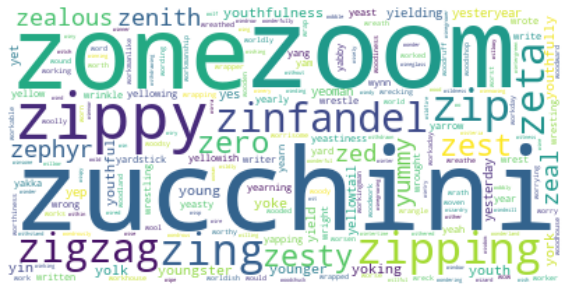

In [111]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
where_zucchini_is = lambda x: "zucchini" in x.lower()

In [130]:
data[data[description].apply(where_zucchini_is)].iloc[8][description]

'Soft mineral tones come on the heels of fresh peach, lemon and kiwi. This is an easygoing Pinot Grigio that would pair with simple foods such as tuna fish salad or fried zucchini flowers.'

In [ ]:
# analyse descriotions on: length (sentences)
# often they say notes of wine and what it is good with
# maybe try find some list of food words and use them in ner
# aroma chart for different wines
# words frequencies for outlier wiens (too expensive but bad and vice versa)
# prediction is useless

In [93]:
def only_leave_specified_pos(text: str, pos_list: typing.List[str]):
    words = nltk.word_tokenize(text)
    words_and_pos = nltk.pos_tag(words)
    required_words = [w for w, pos in words_and_pos if pos in pos_list]
    return ' '.join(required_words)

In [95]:
adjectives = [only_leave_specified_pos(txt, ["JJ"]) for txt in descriptions]

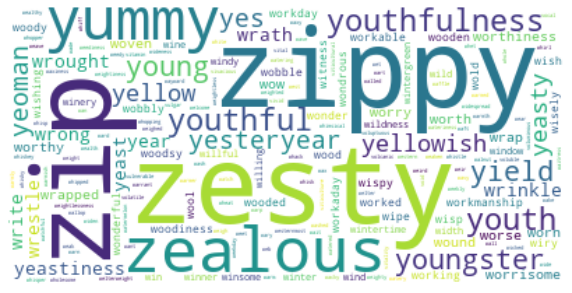

In [102]:
mega_description = ' '.join(adjectives)
wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [97]:
vectorizer = CountVectorizer()
vectorizer.fit(adjectives)

CountVectorizer()

In [101]:
freq = vectorizer.vocabulary_

In [109]:
sorted(vectorizer.vocabulary_, key=lambda x: x[1], reverse=True);

NameError: name 'vectorizer' is not defined

In [22]:
frequency_distribution = nltk.FreqDist(' '.join(descriptions))
print(frequency_distribution.most_common(20))

[(' ', 2296951), ('e', 1592759), ('r', 1122473), ('a', 1086182), ('i', 1041242), ('t', 939727), ('n', 886693), ('l', 792740), ('o', 791442), ('s', 673602), ('c', 556462), ('d', 427395), ('u', 396446), ('y', 391721), ('h', 391367), ('p', 381623), ('f', 325446), ('g', 306613), ('m', 299472), ('b', 254741)]


In [82]:
example = "One Ring to rule them all, One Ring to find them, One Ring to bring them all, And in the Darkness bind them"

In [15]:
country_dict = data[country].value_counts().to_dict()
list_of_other_countries = [k for k,v in country_dict.items() if v<1000]

In [16]:
# groups countries with small number of observations (<1000) into one group named "Other"
mask = data[country].isin(list_of_other_countries)
data[country].mask(mask, 'Other', inplace=True)
data[country].value_counts()

US              40544
Italy           14850
France          14459
Spain            5443
Chile            3735
Portugal         3508
Argentina        3447
Australia        3152
Austria          1959
Other            1876
New Zealand      1865
Germany          1529
South Africa     1481
Name: country, dtype: int64

In [38]:
descriptions = data[description].to_list()

In [39]:
vectorizer = CountVectorizer()  
vectorizer.fit(descriptions)

CountVectorizer()

In [17]:
n=1000

In [18]:
# n highest score wines
data_sorted_by_score = data.sort_values([points], ascending=False)
first_n_sorted_by_score = data_sorted_by_score.iloc[:n]
print(first_n_sorted_by_score[country].value_counts())
first_n_sorted_by_score

US           436
France       305
Italy        150
Australia     27
Spain         26
Germany       20
Austria       18
Portugal      13
Argentina      4
Other          1
Name: country, dtype: int64


,country,description,points,price,variety,province,winery,points_group,log10_price
98647,US,"A spectacular Pinot Noir, but a very young one...",100,100.0,Pinot Noir,California,Williams Selyem,95 to 100,2.000000
92916,US,A perfect score has to be considered in the co...,100,215.0,Cabernet Sauvignon,California,Shafer,95 to 100,2.332438
24151,Italy,"A perfect wine from a classic vintage, the 200...",100,460.0,Merlot,Tuscany,Tenuta dell'Ornellaia,95 to 100,2.662758
19354,US,"In a stunning lineup of Cayuse Syrahs, the En ...",100,65.0,Syrah,Oregon,Cayuse,95 to 100,1.812913
19355,Australia,Not a Cellar Selection in the traditional sens...,100,300.0,Muscat,Victoria,Chambers Rosewood Vineyards,95 to 100,2.477121
...,...,...,...,...,...,...,...,...,...
26368,US,Texture is the name of the game here. We're ta...,95,90.0,Cabernet Sauvignon,California,Chateau St. Jean,95 to 100,1.954243
2759,France,The nose is still shy but already tells of ten...,95,90.0,Pinot Gris,Alsace,Domaine Schoffit,95 to 100,1.954243
47440,France,"Very mineral in character, this young wine is ...",95,150.0,Chardonnay,Burgundy,Domaine Laroche,95 to 100,2.176091
47441,Italy,Ben Ryé can claim to be both a cult wine and a...,95,40.0,Zibibbo,Sicily & Sardinia,Donnafugata,95 to 100,1.602060


In [19]:
# n highest price wines
data_sorted_by_price = data.sort_values([price], ascending=False)
first_n_sorted_by_price = data_sorted_by_price.iloc[:n]
print(first_n_sorted_by_price[country].value_counts())
first_n_sorted_by_price

France       386
US           206
Italy        180
Spain         80
Germany       55
Australia     37
Portugal      26
Chile         12
Argentina     10
Other          6
Austria        2
Name: country, dtype: int64


,country,description,points,price,variety,province,winery,points_group,log10_price
34920,France,"A big, powerful wine that sums up the richness...",99,2300.0,Bordeaux-style Red Blend,Bordeaux,Château Latour,95 to 100,3.361728
13318,US,The nose on this single-vineyard wine from a s...,91,2013.0,Chardonnay,California,Blair,90 to 94,3.303844
34922,France,"A massive wine for Margaux, packed with tannin...",98,1900.0,Bordeaux-style Red Blend,Bordeaux,Château Margaux,95 to 100,3.278754
26296,France,A wine that has created its own universe. It h...,100,1400.0,Chardonnay,Champagne,Krug,95 to 100,3.146128
34939,France,"The purest Cabernet Sauvignon fruit, with dark...",96,1300.0,Bordeaux-style Red Blend,Bordeaux,Château Mouton Rothschild,95 to 100,3.113943
...,...,...,...,...,...,...,...,...,...
18802,US,"With firm acidity and big tannins, this Cabern...",92,150.0,Cabernet Sauvignon,California,Notre Vin,90 to 94,2.176091
6005,Spain,"Gorgeous aromas of toasty oak, wood smoke, min...",97,150.0,Tinto Fino,Northern Spain,Emilio Moro,95 to 100,2.176091
20069,Italy,The Octavius Riserva shows the heat of the 200...,90,150.0,"Corvina, Rondinella, Molinara",Veneto,Marchesi Fumanelli,90 to 94,2.176091
117080,Spain,Plenty of new oak is announced via aromas of c...,89,150.0,Bordeaux-style Red Blend,Catalonia,Torres,85 to 89,2.176091


In [20]:
# more down to earth prices
wines_cheaper_than_50 = data[data[price] <= 50.0]
wines_cheaper_than_50_sorted = wines_cheaper_than_50.sort_values([price], ascending=False)
firts_100_cheaper_sorted = wines_cheaper_than_50_sorted.iloc[:n]
print(firts_100_cheaper_sorted[country].value_counts())
firts_100_cheaper_sorted

US              577
Italy           144
France           97
Spain            34
Argentina        32
Australia        30
Portugal         19
Other            17
Chile            15
Austria          14
Germany           9
New Zealand       7
South Africa      5
Name: country, dtype: int64


,country,description,points,price,variety,province,winery,points_group,log10_price
64155,US,I tasted this wine with Kathy Josephs' Fiddles...,89,50.0,Pinot Noir,California,Hitching Post,85 to 89,1.69897
61057,US,This is the second vintage Sbragia has accesse...,94,50.0,Cabernet Sauvignon,California,Sbragia,90 to 94,1.69897
61095,Argentina,"Pitch dark in color, with a huge, oaky/earthy ...",91,50.0,Red Blend,Other,Michel Torino,90 to 94,1.69897
61172,US,This vintage is vineyard designated (Sheridan ...,87,50.0,Merlot-Cabernet Sauvignon,Washington,Owen-Sullivan,85 to 89,1.69897
117710,US,"Not on par with the past several vintages, the...",84,50.0,Bordeaux-style Red Blend,California,Franciscan,80 to 84,1.69897
...,...,...,...,...,...,...,...,...,...
86852,France,"Smooth and ripe, this is full of red fruits th...",89,50.0,Pinot Noir,Burgundy,Domaines Devillard,85 to 89,1.69897
69424,US,Tastes like it benefited from being held back ...,90,50.0,Cabernet Sauvignon,California,Spring Mountain Vineyard,90 to 94,1.69897
73397,Other,"Blackberry, plum and savory meat aromas give t...",90,50.0,Red Blend,Letrinon,Mercouri Estate,90 to 94,1.69897
73602,US,"With rich, ripe black and red cherry, mocha, c...",90,50.0,Merlot,California,Madorom,90 to 94,1.69897


In [21]:
# even more down to earth prices
wines_cheaper_than_20 = data[data[price] <= 20.0]
wines_cheaper_than_20_sorted = wines_cheaper_than_20.sort_values([price], ascending=False)
firts_n_cheaper_sorted = wines_cheaper_than_20_sorted.iloc[:n]
print(firts_n_cheaper_sorted[country].value_counts())
firts_n_cheaper_sorted

France          337
US              248
Italy           196
Portugal         66
Argentina        25
Austria          24
Spain            24
Chile            24
Other            21
Australia        14
New Zealand       8
Germany           7
South Africa      6
Name: country, dtype: int64


,country,description,points,price,variety,province,winery,points_group,log10_price
91734,Italy,Perfumed Indian tea and jasmine open the nose ...,87,20.0,Nebbiolo,Piedmont,Ponchione Maurizio,85 to 89,1.30103
88657,France,"Smooth and ripe, this has the warmth of 2009, ...",88,20.0,Gewürztraminer,Alsace,Dopff & Irion,85 to 89,1.30103
88655,France,"A pure, fruity wine, this delights with its cr...",88,20.0,Riesling,Alsace,Domaine François Schmitt,85 to 89,1.30103
88652,Italy,"On the nose, the sparkling wine delivers tones...",88,20.0,Glera,Veneto,Carmina,85 to 89,1.30103
88582,Austria,"The partner to Beck's Zweigelt, this is every ...",90,20.0,Blaufränkisch,Burgenland,Judith Beck,90 to 94,1.30103
...,...,...,...,...,...,...,...,...,...
37717,Other,"This is a ripe and rich Chardonnay, with exube...",88,20.0,Chardonnay,Galilee,Golan Heights Winery,85 to 89,1.30103
37432,France,"This is a textured, dense and concentrated sel...",88,20.0,Chardonnay,Burgundy,Albert Bichot,85 to 89,1.30103
81809,US,"Not really sweet, and not entirely Riesling (t...",84,20.0,Riesling,Washington,Lake Chelan,80 to 84,1.30103
37729,Italy,Gherardino offers tight fruit nuances of fores...,88,20.0,Sangiovese,Tuscany,Villa Vignamaggio,85 to 89,1.30103


In [33]:
# cheap wine but with high score
cheap_wines = data[data[price]<=20]
# cheap_wines_high_score = cheap_wines[cheap_wines[points_group]=="95 to 100"]
cheap_wines_high_score = cheap_wines[cheap_wines[points]>=93].sort_values([price], ascending=False)
print(cheap_wines_high_score[country].value_counts())
print(cheap_wines_high_score[variety].value_counts())

US              64
France          11
Portugal         6
Spain            4
Austria          4
Italy            3
South Africa     2
Australia        2
Argentina        1
Name: country, dtype: int64
Riesling                    19
Chardonnay                   8
Sauvignon Blanc              8
Red Blend                    5
Portuguese Red               5
Viognier                     5
Cabernet Sauvignon           4
Pinot Noir                   3
Sherry                       3
White Blend                  3
Pinot Gris                   3
Syrah                        2
Malbec                       2
Port                         2
Rhône-style Red Blend        2
Bordeaux-style Red Blend     2
Vermentino                   2
Tannat                       2
Muscat                       1
Orange Muscat                1
Pedro Ximénez                1
Moscato Giallo               1
Chenin Blanc                 1
Pinot Blanc                  1
Tannat-Cabernet Franc        1
Rosé                      

In [34]:
# expensive wine with low score
expensive_wines = data[data[price]>100]
expensive_wines_low_score = expensive_wines[expensive_wines[points_group]=="80 to 84"]
expensive_wines_low_score = expensive_wines_low_score.sort_values([price], ascending=False)
expensive_wines_low_score.iloc[3][description]

'Mature, with tomato and dill aromas prior to severe cherry tomato, rhubarb and vanilla flavors. At all points the wine places zest before richness, acid before body. And while it has its aged, old-world virtues, it fails to share much love along the way.'

In [24]:
# TODO
# write some text
# deal with plots
# analysis
    # price correlates with points?
    # overall price analysis
    # where is the best wine?
    # where is the most expensive wine?
    # what wine is cheap but has high score? what are the descrition?
    # what wine is expensive but has low score?
    #ANOVA
# nlp
    # is it possible to predict score from description?
    # what are most common words?/per wine category?
    # sweet-savory cart?
    # word clouds
    
# a chart by country (where there are more than 1000 observations) featuring:
#     10 most expensive wines
#     10 cheapest wines
#     10 higheest score wines
#     the most popular variety
#     cheap but high
#     expensive but low
    

In [25]:
us_data = data[data[country] == 'US']
us_data_price_sorted = us_data.sort_values([price], ascending=False)
most_expensive_wines = us_data_price_sorted.iloc[:100]
cheapest_wines = us_data_price_sorted.iloc[-100:]

In [26]:
us_data[variety].value_counts()[:10]

Pinot Noir                  6682
Cabernet Sauvignon          6045
Chardonnay                  5162
Syrah                       2714
Zinfandel                   2401
Merlot                      2295
Red Blend                   2163
Sauvignon Blanc             1705
Bordeaux-style Red Blend    1237
Riesling                    1089
Name: variety, dtype: int64

In [27]:
high_score = us_data[us_data[points]>=95].sort_values([price], ascending=False)
print(f"Price span: {high_score[price].min()} - {high_score[price].max()}")
# print(high_score[variety].value_counts())

high_score_cheap = high_score[high_score[price]<=20]
high_score_cheap

Price span: 20.0 - 625.0


,country,description,points,price,variety,province,winery,points_group,log10_price
22079,US,"With residual sugar at about 1.35%, this balan...",95,20.0,Riesling,Washington,Poet's Leap,95 to 100,1.30103
85050,US,"Truly stunning, the Lewis Estate Riesling from...",95,20.0,Riesling,Washington,Dunham,95 to 100,1.30103
56971,US,"Superb fruit highlights this tight, sculpted S...",96,20.0,Syrah,Washington,Rulo,95 to 100,1.30103
104504,US,"Simply astonishing for its price, this toasty,...",95,20.0,Chardonnay,Washington,Rulo,95 to 100,1.30103
51461,US,Spectacular is the word that comes to mind her...,95,20.0,Riesling,Washington,Januik,95 to 100,1.30103


In [28]:
low_score = us_data[us_data[points]<=84].sort_values([price], ascending=False)
low_score_pricy = low_score[low_score[price]>=50]
low_score_pricy[variety].value_counts()

Cabernet Sauvignon                   110
Pinot Noir                            43
Bordeaux-style Red Blend              21
Red Blend                             18
Zinfandel                             15
Merlot                                11
Syrah                                  9
Chardonnay                             7
Cabernet Blend                         4
Meritage                               4
Cabernet Franc                         3
Sangiovese                             2
Barbera                                2
Petite Sirah                           2
Port                                   2
Malbec                                 2
Rhône-style Red Blend                  2
Sparkling Blend                        1
Cabernet Sauvignon-Merlot              1
Petite Verdot                          1
Syrah-Viognier                         1
Roussanne                              1
Cabernet Sauvignon-Syrah               1
Cabernet Sauvignon-Cabernet Franc      1
White Blend     

In [29]:
print(most_expensive_wines[variety].value_counts())
print('\n')
print(cheapest_wines[variety].value_counts())

Cabernet Sauvignon          53
Bordeaux-style Red Blend    30
Cabernet Blend               9
Red Blend                    5
Chardonnay                   1
Sparkling Blend              1
Pinot Noir                   1
Name: variety, dtype: int64


Chardonnay                  21
Zinfandel                   15
Cabernet Sauvignon          12
Merlot                      11
Pinot Grigio                10
Shiraz                       8
Red Blend                    5
Sauvignon Blanc              4
Pinot Noir                   2
Riesling                     2
Chenin Blanc                 2
White Blend                  2
White Riesling               1
Viognier                     1
Rosé                         1
Morio Muskat                 1
Bordeaux-style Red Blend     1
Syrah                        1
Name: variety, dtype: int64


In [30]:
most_expensive_wines

,country,description,points,price,variety,province,winery,points_group,log10_price
13318,US,The nose on this single-vineyard wine from a s...,91,2013.0,Chardonnay,California,Blair,90 to 94,3.303844
18617,US,The former basketball star's initial release i...,97,625.0,Cabernet Sauvignon,California,Yao Ming,95 to 100,2.795880
128104,US,"Here's a big, flashy, cult-style wine if ever ...",94,500.0,Bordeaux-style Red Blend,California,Harlan Estate,90 to 94,2.698970
114280,US,"Ripe and flashy, offering tiers of cassis, cho...",96,500.0,Cabernet Blend,California,Screaming Eagle,95 to 100,2.698970
52268,US,"Smells a bit minty and peppery, but once in th...",95,450.0,Bordeaux-style Red Blend,California,Harlan Estate,95 to 100,2.653213
...,...,...,...,...,...,...,...,...,...
6325,US,A 100% Cabernet Sauvignon from a prominent sit...,94,185.0,Cabernet Sauvignon,California,B Cellars,90 to 94,2.267172
14,US,"With its sophisticated mix of mineral, acid an...",95,185.0,Pinot Noir,Oregon,Domaine Serene,95 to 100,2.267172
47700,US,The 2008 vintage wasn't the greatest ever in N...,94,185.0,Cabernet Sauvignon,California,Staglin,90 to 94,2.267172
10290,US,"The producer's highest-end bottling, this is t...",95,185.0,Cabernet Sauvignon,California,Ramey,95 to 100,2.267172


In [31]:
cheapest_wines

,country,description,points,price,variety,province,winery,points_group,log10_price
141029,US,"I want to like this wine, and it's okay for si...",83,7.0,Pinot Grigio,California,Coastal Ridge,80 to 84,0.845098
7745,US,"This brightly acidic, clean wine doesn't appea...",87,7.0,Pinot Grigio,California,flipflop,85 to 89,0.845098
49296,US,Here is another fine effort from a re-invigora...,87,7.0,Merlot,Washington,Washington Hills,85 to 89,0.845098
46814,US,"A simple little Cabernet, soft and silky, with...",83,7.0,Cabernet Sauvignon,California,CK Mondavi,80 to 84,0.845098
46822,US,"This is a Bordeaux blend, and while it's a sim...",83,7.0,Bordeaux-style Red Blend,California,CK Mondavi,80 to 84,0.845098
...,...,...,...,...,...,...,...,...,...
114167,US,"Easy, simple peach and strawberry flavors are ...",83,4.0,Zinfandel,California,Round Hill,80 to 84,0.602060
119285,US,"Packaged in a cute yellow recyclable Tetrapak,...",84,4.0,Chardonnay,California,Bandit,80 to 84,0.602060
119295,US,"A good everyday Merlot, dry and rich in tannin...",84,4.0,Merlot,California,Bandit,80 to 84,0.602060
25645,US,"There's a lot going on in this Merlot, which i...",86,4.0,Merlot,California,Bandit,85 to 89,0.602060


### References

https://www.statisticshowto.com/tukey-test-honest-significant-difference/  
https://www.statology.org/interpret-anova-results-in-r/  
https://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/  
http://www.socr.ucla.edu/Applets.dir/F_Table.html  
https://www.reneshbedre.com/blog/anova.html  
https://data.library.virginia.edu/understanding-q-q-plots/  

food

https://vegetablesfruitsgrains.com/
https://www.macmillandictionary.com/thesaurus-category/british/types-of-meat
https://www.enchantedlearning.com/wordlist/fish.shtml

Descriptive words
https://www.scarymommy.com/words-to-describe-food
https://france-amerique.com/en/fifteen-adjectives-to-describe-fine-wines/
https://www.words-to-use.com/words/wine/